In [4]:
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

Set all the Constants

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Training/Potato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  # Width or Height  256 * 256
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [7]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


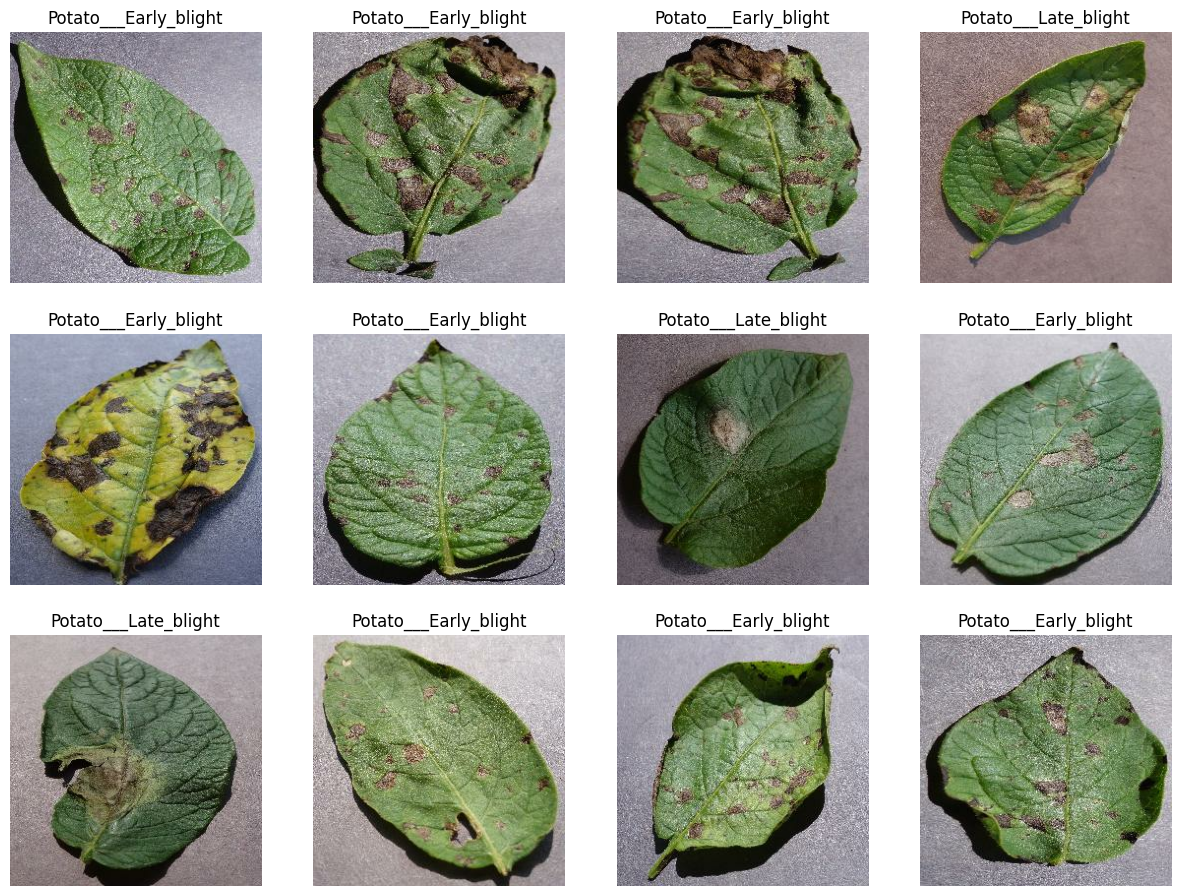

In [9]:
plt.figure(figsize=(15, 15))                                   # ploting the image here
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
type(image_batch[i])

tensorflow.python.framework.ops.EagerTensor

In [11]:
type(image_batch[i].numpy())

numpy.ndarray

In [12]:
# * Function to Split Dataset
#   Dataset should be bifurcated into 3 subsets, namely:

# 1. Training: Dataset to be used  while training
# 2. Validation: Dataset to be tested against while training
# 3. Test: Dataset to be tested against after we trained a model

In [13]:
 len(dataset)

68

In [14]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [15]:
# Total Data Will be The 80 % And then we do the further process which is like :

# Traning Data = 80%
# Testing Data = 20%
#                ==> test data       = 10%
#                ==> valdation data  = 10%

this is the One By One trian and Test Split

In [16]:
train_ds = dataset.take(54)            #  Traning Data
len(train_ds)

54

In [17]:
test_ds = dataset.skip(54)             # Testing Data

In [18]:
len(test_ds)

14

In [19]:
val_ds = test_ds.take(6)                # Validation Data
len(val_ds)

6

In [20]:
test_ds = test_ds.skip(6)
len(test_ds)

8

Creating the Fun For Traning and Teting Data

In [21]:
def get_data_partitions_tf(ds,train_split=0.8,val_split =0.1,test_split =0.1,shuffle=True,shuffle_size=10000):

    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)                    # this is the Fun creating for the split data into train and test
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)



    return train_ds, val_ds, test_ds



In [22]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

In [23]:
 len(train_ds)

54

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

8

Cache, Shuffle, and Prefetch the Dataset

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)    # we are doing here cache , prefetch and shuffel on data
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)      # in the Aboev redme file i will give the full info
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Normalizing the Image bcz the rang is 0-255

In [27]:
for image_batch, labels_batch in dataset.take(1):   # calculating the image shape
    print(image_batch[0].numpy().shape)

(256, 256, 3)


In [28]:
for image_batch, labels_batch in dataset.take(1):     # 1 image in numpay how look like this is demonstration
    print(image_batch[0].numpy())

[[[162. 166. 177.]
  [166. 170. 181.]
  [177. 181. 192.]
  ...
  [165. 163. 176.]
  [160. 158. 171.]
  [162. 160. 173.]]

 [[207. 211. 222.]
  [175. 179. 190.]
  [141. 145. 156.]
  ...
  [157. 155. 168.]
  [153. 151. 164.]
  [156. 154. 167.]]

 [[186. 190. 201.]
  [182. 186. 197.]
  [195. 199. 210.]
  ...
  [157. 155. 168.]
  [153. 151. 164.]
  [154. 152. 165.]]

 ...

 [[155. 153. 166.]
  [153. 151. 164.]
  [157. 155. 168.]
  ...
  [142. 139. 150.]
  [142. 139. 150.]
  [127. 124. 135.]]

 [[185. 183. 196.]
  [173. 171. 184.]
  [162. 160. 173.]
  ...
  [148. 145. 156.]
  [130. 127. 138.]
  [128. 125. 136.]]

 [[176. 174. 187.]
  [175. 173. 186.]
  [175. 173. 186.]
  ...
  [111. 108. 119.]
  [143. 140. 151.]
  [139. 136. 147.]]]


# Resizing and Normalization



```

Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it
to the desired size. Moreover, to improve model performance, we
should normalize the image pixel value (keeping them in range 0
and 1 by dividing by 256). This should happen while training as
well as inference. Hence we can add that as a layer in our
Sequential Model.

You might be thinking why do we need to resize (256,256) image
to again (256,256). You are right we don't need to but this will
be useful when we are done with the training and start using the
model for predictions. At that time somone can supply an image
that is not (256,256) and this layer will resize it
```



In [29]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import Rescaling, Normalization


In [30]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1.0/255),
])

# Data Augmentation

In [31]:
 data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomContrast(0.2)
])

# Model HP Tunning

In [32]:
pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


In [33]:
# from keras_tuner import RandomSearch
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# def build_model(hp):

#     model = Sequential()

#     kernel_size = hp.Int('kernel_size', 3, 5, step=2)

#     kernel_choice = hp.Choice('kernel_size', ['3x3', '5x5'])
#     if kernel_choice == '3x3':
#       kernel_size = (3, 3)
#     else:
#       kernel_size = (5, 5)

#     # Conv Layer

#     model.add(Conv2D(
#         filters=hp.Choice('conv_filters', [32, 64, 128]),
#         kernel_size=hp.Choice('kernel_size', [(3,3), (5,5)]),
#         activation='relu',
#         input_shape=(128, 128, 3)
#     ))

#     model.add(MaxPooling2D(pool_size=(2, 2)))

#     # Dropout Layer
#     model.add(Dropout(hp.Float('dropout_rate', 0.2, 0.5, step=0.1)))

#     model.add(Flatten())

#     # Dense Layer
#     model.add(Dense(hp.Int('dense_units', 64, 256, step=64), activation='relu'))

#     model.add(Dense(3, activation='softmax'))  # For 3 classes (Healthy, Early, Late)

#     model.compile(
#         optimizer='adam',
#         loss='sparse_categorical_crossentropy',
#         metrics=['accuracy']
#     )

#     return model


In [34]:
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=10,
#     directory='cnn_tuning',
#     project_name='potato_disease'
# )

# tuner.search(train_ds, validation_data=val_ds, epochs=10)


In [35]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)

n_classes = 3

model = models.Sequential([

    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),

    layers.Dense(n_classes, activation='softmax'),



])

model.build(input_shape=input_shape)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [36]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=35,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 141s 195ms/step - accuracy: 0.4817 - loss: 0.9549 - val_accuracy: 0.6510 - val_loss: 0.8236
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.6779 - loss: 0.7131 - val_accuracy: 0.7135 - val_loss: 0.5868
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8277 - loss: 0.3791 - val_accuracy: 0.8750 - val_loss: 0.3412
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8792 - loss: 0.2935 - val_accuracy: 0.9271 - val_loss: 0.1648
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.9081 - loss: 0.2028 - val_accuracy: 0.9583 - val_loss: 0.1374
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9425 - loss: 0.1664 - val_accuracy: 0.9792 - val_loss: 0.0988
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9316 - loss: 0.1833 - val_accuracy: 0.9792 - val_loss: 0.0917
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9584 - loss: 0.1226 - val_accuracy: 0.9688 

# Good Model (Well Generalized)

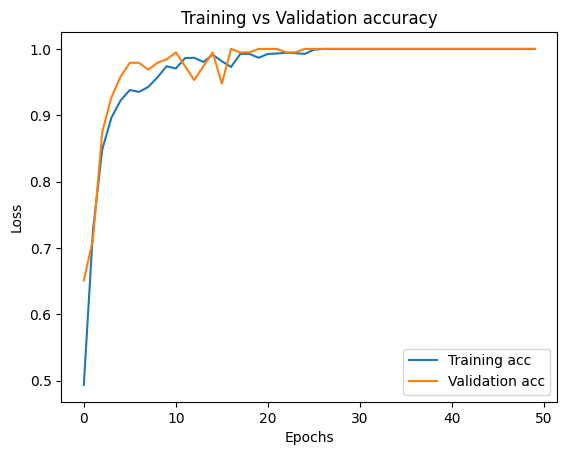

In [46]:
plt.plot(history.history['accuracy'], label='Training acc')
plt.plot(history.history['val_accuracy'], label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation accuracy")
plt.show()

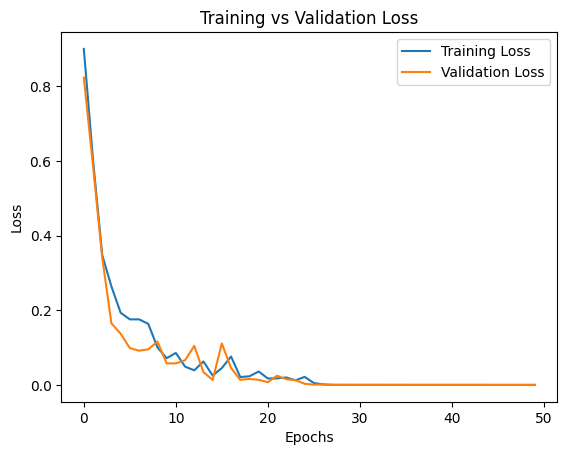

In [39]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# how bad the model's predictions are

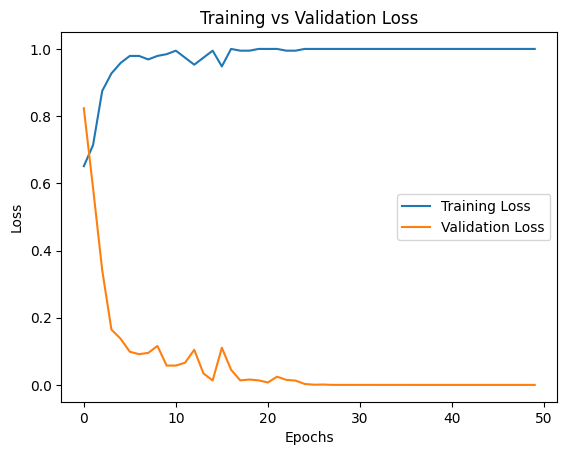

In [44]:
plt.plot(history.history['val_accuracy'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [40]:
len(test_ds)

8

In [41]:
acc = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9927 - loss: 0.0140


In [42]:
acc

[0.01729145273566246, 0.9921875]

Testinf On data

Actual Label: Potato___Early_blight
first Image
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Predicted Label Potato___Early_blight


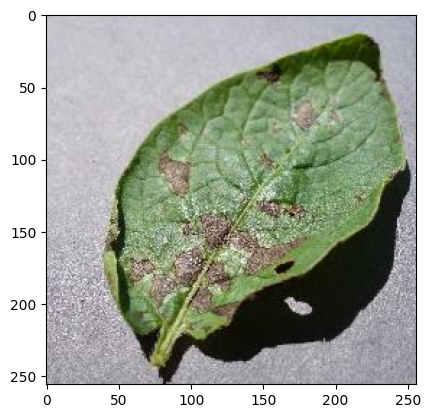

In [67]:
import numpy as np

for image_batch,labels_batch in test_ds.take(1):

  first_image = image_batch[0].numpy().astype("uint8")

  print("Actual Label:",class_names[labels_batch[0].numpy()])

  plt.imshow(image_batch[0].numpy().astype("uint8"))

  print("first Image")
  batch_pred =  model.predict(image_batch)
  print("Predicted Label",class_names[np.argmax(batch_pred[0])])


# New Prediction Model Actual Wala

In [72]:
def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


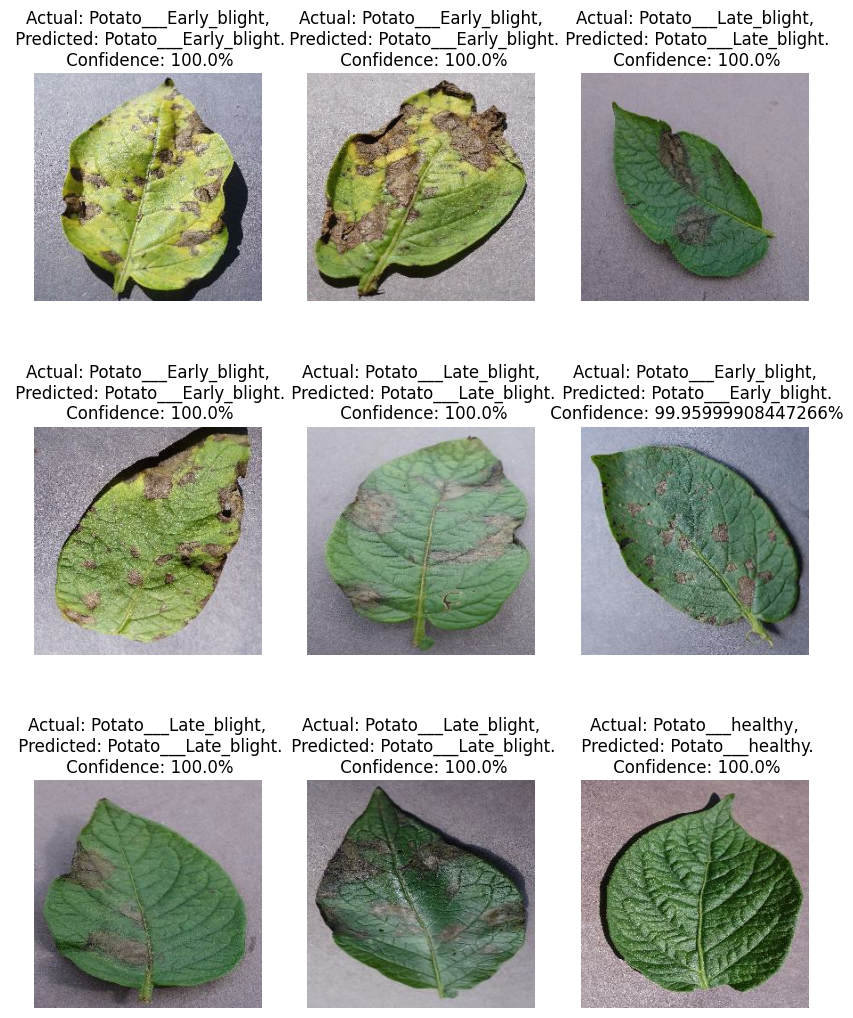

In [75]:
plt.figure(figsize=(10, 13))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

# Saving the Model</p>
We append the model to the list of models as a new version

In [78]:
import os

# Filter out non-integer directory names before converting to int
model_version=max([int(i) for i in os.listdir("/content/Potato_disease_Model") if i.isdigit()] + [0])+1

# Add the .keras extension to the filepath
model.save(f"/content/Potato_disease_Model/version_1{model_version}.keras")